In [1]:
from huggingface_hub import login

login()

In [2]:
import pandas as pd
import datasets
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn.parallel import DataParallel
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
train_data = pd.read_csv('./described_dataset_label.csv',sep='\t',encoding='latin-1')
print(f'coumns:{[x for x in train_data.columns]}')

coumns:['ID', 'FILE', 'AUTHOR', 'BORN-DIED', 'TITLE', 'DATE', 'TECHNIQUE', 'LOCATION', 'FORM', 'TYPE', 'SCHOOL', 'TIMELINE', 'URL']


In [4]:
features = ['FILE','AUTHOR','TECHNIQUE','URL']
train_data = train_data[features]
train_data = train_data[:1000]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(',').str[0]
train_data['TECHNIQUE'] = train_data['TECHNIQUE'].str.split(':').str[0]
train_data.head()

,FILE,AUTHOR,TECHNIQUE,URL
0,./images/1.jpg,"AACHEN, Hans von",Oil on copper,"The painting, displaying the characteristic Ma..."
1,./images/2.jpg,"AACHEN, Hans von",Oil on canvas,The representation of this group is related to...
2,./images/3.jpg,"AACHEN, Hans von",Copperplate,At the end of the 16th century the court of Em...
3,./images/4.jpg,"AACHEN, Hans von",Oil on canvas,Rudolf II (1552-1612) was the son of the Holy ...
4,./images/5.jpg,"AACHEN, Hans von",Oil on canvas,Hans von Aachen was an artist who fully embrac...


In [5]:
train_data.dropna()
train_data = train_data[train_data['URL'] != 0]

In [6]:
train_data = train_data.rename(columns={'FILE':'image','AUTHOR':'author', 'TECHNIQUE':'style','URL':'description'})

In [7]:
labels_auth = train_data['author'].unique()
label2id_auth, id2label_auth = dict(), dict()
for i, label in enumerate(labels_auth):
    label2id_auth[label]=i
    id2label_auth[i]=label

In [8]:
labels_sty = train_data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [9]:
train_data['author'] = train_data['author'].map(label2id_auth)
train_data['style'] = train_data['style'].map(label2id_sty)
train_data.columns

Index(['image', 'author', 'style', 'description'], dtype='object')

In [10]:
train_dataset = datasets.Dataset.from_pandas(train_data).cast_column('image',datasets.Image())
train_dataset_git = datasets.Dataset.from_pandas(train_data[['image','description']]).cast_column('image',datasets.Image())
train_dataset_vit_auth = datasets.Dataset.from_pandas(train_data[['image','author']]).cast_column('image',datasets.Image())
train_dataset_vit_style = datasets.Dataset.from_pandas(train_data[['image','style']]).cast_column('image',datasets.Image())
print(train_dataset)

Dataset({
    features: ['image', 'author', 'style', 'description'],
    num_rows: 1000
})


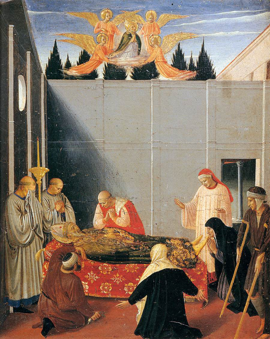

Description: The three paintings on the predella of the Perugia Triptych depict the story of St Nicholas.The right part of the third predella painting shows the death of the Saint. The starkness of a lightly articulated wall forces attention on the dying saint.
Author: 90
Technique: 72


In [11]:
sample = train_dataset[605]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
caption = sample['description']
author = sample['author']
technique = sample['style']
print(f'Description: {caption}')
print(f'Author: {author}')
print(f'Technique: {technique}')

In [12]:
from transformers import AutoModelForImageClassification

checkpoint = './model_checkpoints/model_auth'
model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

OSError: Can't load the configuration of './model_checkpoints/model_auth'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure './model_checkpoints/model_auth' is the correct path to a directory containing a config.json file

In [14]:
from transformers import AutoModelForImageClassification

checkpoint = './Models_with_Trainer/model_checkpoints/model_sty'
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels = len(labels_auth),
    id2label = id2label_auth,
    label2id = label2id_auth,
    ignore_mismatched_sizes=True
).to(device)

OSError: Can't load the configuration of './Models_with_Trainer/model_checkpoints/model_sty'. If you were trying to load it from 'https://huggingface.co/models', make sure you don't have a local directory with the same name. Otherwise, make sure './Models_with_Trainer/model_checkpoints/model_sty' is the correct path to a directory containing a config.json file

In [16]:
from transformers import AutoImageProcessor

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

checkpoint= 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [17]:
from transformers import AutoImageProcessor

#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

image_processor = AutoImageProcessor.from_pretrained(checkpoint)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [18]:
from transformers import AutoProcessor
processor_capt = AutoProcessor.from_pretrained("microsoft/git-base-coco")

In [19]:
from transformers import AutoModelForCausalLM

model_capt = AutoModelForCausalLM.from_pretrained('./model_checkpoints/model_capt').to(device)

In [20]:
inputs = processor_capt(images = image, return_tensors='pt').to(device)
pixel_values = inputs.pixel_values

generated_ids = model_capt.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor_capt.batch_decode(generated_ids,skip_special_tokens=True)[0]
print(generated_caption)

the two prophets'statues flanking the central portal on the facade of the cathedral in fidenza, david on the left and ezekiel on the right, are standing in niches and are very rare examples of three - dimensional romanesque sculpture.


In [21]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])

ADRIANO FIORENTINO
ADLER, Salomon


In [22]:
predicted_label_auth = model_clas_auth.config.id2label[predicted_label_auth]
predicted_label_sty = model_clas_sty.config.id2label[predicted_label_sty]
text="You are an art critic. Improve the following art description" + generated_caption + "using Author: " + predicted_label_auth +' and Style: '+predicted_label_sty

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer

model_name = "meta-llama/Llama-2-7b-hf" 

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)

inputs = tokenizer(text, return_tensors='pt')
output = model.generate(**inputs, penalty_alpha=0.6, top_k=4, max_new_tokens=100)
generated_text = tokenizer.batch_decode(output[-1], skip_special_tokens=True)
print(generated_text)

# Project Work

In [ ]:
from diffusers import DiffusionPipeline
import torch

pipe = DiffusionPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipe.to("cuda")

# if using torch < 2.0
# pipe.enable_xformers_memory_efficient_attention()

prompt = generated_text + " Using the style " + predicted_label_sty
images = pipe(prompt=prompt).images[0]

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
imgplot = plt.imshow(images)
plt.show()